# Quasi static forces from model test

# Purpose
Calculating the quasi static forces from a model test by assuming the added masses. This can then be compared to the static VCT calculations.

# Setup

In [ ]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
#import src.models.nonlinear_martin_vmm as vmm
#import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as vmm
#import src.nonlinear_vmm_equations as eq
import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as model
from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

# Methodology
Generally:

$ F = m \cdot a $

if $m$ (including added mass) can is known $F$ should be possible to calculate from a dynamic model test.

For the ship in the Y-direction this can be written as:

## Y:

In [ ]:
Math(vlatex(eq.Y_eom))

In [ ]:
Math(vlatex(eq.fy_eq))

In [ ]:
Y_eq = eq.Y_eom.subs(eq.Y_nonlin,sp.solve(eq.fy_eq,Y_nonlin)[0])
Math(vlatex(Y_eq))

In [ ]:
eq_Y_qs = sp.Eq(Y_qs,
      sp.solve(Y_eq, Y_qs)[0])
Math(vlatex(eq_Y_qs))

In [ ]:
subs = {value:key for key,value in eq.p.items()}
Y_qs_lambda = lambdify(eq_Y_qs.subs(subs).rhs)

## X:

In [7]:
Math(vlatex(eq.X_eom))

<IPython.core.display.Math object>

In [8]:
Math(vlatex(eq.fx_eq))

<IPython.core.display.Math object>

In [9]:
X_eq = eq.X_eom.subs(eq.X_nonlin,sp.solve(eq.fx_eq,X_nonlin)[0])
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [10]:
eq_X_qs = sp.Eq(X_qs,
      sp.solve(X_eq, X_qs)[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [11]:
subs = {value:key for key,value in eq.p.items()}
X_qs_lambda = lambdify(eq_X_qs.subs(subs).rhs)

## N:

In [12]:
Math(vlatex(eq.N_eom))

<IPython.core.display.Math object>

In [13]:
Math(vlatex(eq.mz_eq))

<IPython.core.display.Math object>

In [14]:
N_eq = eq.N_eom.subs(eq.N_nonlin,sp.solve(eq.mz_eq,N_nonlin)[0])
Math(vlatex(N_eq))

<IPython.core.display.Math object>

In [15]:
eq_N_qs = sp.Eq(N_qs,
      sp.solve(N_eq, N_qs)[0])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

In [16]:
N_qs_lambda = lambdify(eq_N_qs.subs(subs).rhs)

In [17]:
u1d,v1d,r1d = sp.symbols('u1d, v1d, r1d')
subs = [
    (u.diff(),u1d),
    (v.diff(),v1d),
    (r.diff(),r1d),

]
eq_X_ = X_eq.subs(subs)
eq_Y_ = Y_eq.subs(subs)
eq_N_ = N_eq.subs(subs)


A,b = sp.linear_eq_to_matrix([eq_X_,eq_Y_,eq_N_],[u1d,v1d,r1d])
#A,b = sp.linear_eq_to_matrix([eq_Y_,eq_N_],[v1d,r1d])

In [18]:
Math(vlatex(eq_Y_))

<IPython.core.display.Math object>

In [19]:
A

Matrix([
[-X_{\dot{u}} + m,                       -X_{\dot{v}},         -X_{\dot{r}}],
[    -Y_{\dot{u}},                   -Y_{\dot{v}} + m, -Y_{\dot{r}} + m*x_G],
[               0, -N_{\dot{u}} - N_{\dot{v}} + m*x_G,    I_z - N_{\dot{r}}]])

In [20]:
Math(vlatex(b))

<IPython.core.display.Math object>

In [21]:
lambdify(A.inv()*b)

<function _lambdifygenerated(I_z, Dummy_102, Dummy_101, Dummy_100, Dummy_99, Dummy_98, Dummy_97, Dummy_96, Dummy_95, _Dummy_94, delta, m, r, u, v, x_G)>

# Quasi static forces from model tests

## Load test

In [22]:
df_runs = mdl.runs()

In [23]:
#id=22773
#id=22616
id=22774
#id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)
df['-delta'] = -df['delta']
df['V'] = np.sqrt(df['u']**2 + df['v']**2)

In [24]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
beam                                                             0.946602
comment                                                       Circle 35SB
date                                                           2020-09-23
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                                               0.136092
kg                                                               0.438908
lcg                                   

In [25]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,-delta,V
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,-0.000656,-0.000609,-0.151412,0.0,-0.339918,10.131507,1.0,-0.005218,-0.005050,-0.139995,0.0,2.105017,11.329219,-0.003520,-0.006034,-0.002206,-0.019749,-0.113032,-0.008359,8.564107,3.610750,-0.091055,9.544681,5.520960,0.110906,-0.003490,0.645772,14.89,0.0,-0.000925,0.000848,0.000502,-0.000611,8.348096,-0.000032,0.001924,1.915455,-0.005175,-0.017840,1.806687,-8.724901e-03,8.369782,0.945042,-0.000008,-0.000052,-0.000524,-0.000006,-0.000646,-0.000004,0.000012,0.945042,0.000086,-0.017840,-0.000008,-0.000006,1.806687,-0.000004,0.000012,-0.000091,0.003490,0.945042
0.010002,0.0,1.0,-0.000656,-0.000656,-0.396389,0.0,0.219698,10.131507,1.0,-0.005245,-0.005439,-0.111403,0.0,-0.924629,11.329219,-0.015771,-0.022151,-0.006724,-0.002355,-0.080796,-0.015448,8.593354,3.640363,-0.094302,9.547651,5.524301,0.108929,-0.003490,0.645772,14.89,0.0,-0.000975,0.000909,-0.000228,-0.000698,8.367255,-0.000084,0.001745,0.953896,-0.003781,0.000231,0.901220,-4.362014e-03,8.369043,0.932046,-0.001763,-0.000073,-0.000516,-0.000060,-0.000682,-0.000111,0.000104,0.932046,0.000120,0.000231,-0.001762,-0.000061,0.901220,-0.000111,0.000104,-0.000128,0.003490,0.932046
0.020002,0.0,1.0,-0.000621,-0.000656,-0.493565,0.0,0.605640,10.131507,1.0,-0.005259,-0.005439,-0.028020,0.0,-1.870188,11.329219,0.040328,0.001701,0.022316,0.053691,-0.053718,-0.031559,8.604683,3.695781,-0.095392,9.543788,5.475323,0.105839,-0.003497,0.645772,14.89,0.0,-0.001125,0.000796,0.000519,-0.000698,8.367180,-0.000107,0.001928,0.427952,0.004017,0.000190,0.018491,6.938894e-18,8.370812,0.928423,-0.002983,-0.000080,-0.000496,-0.000110,-0.000694,-0.000185,0.000202,0.928423,0.000148,0.000190,-0.002983,-0.000112,0.018491,-0.000185,0.000202,-0.000160,0.003497,0.928423
0.030022,0.0,1.0,-0.000635,-0.000656,-0.352199,0.0,-0.031164,10.131507,1.0,-0.005231,-0.005439,0.023558,0.0,-2.352615,11.329219,0.015180,0.027487,0.035222,-0.044229,-0.123347,-0.007714,8.579641,3.766466,-0.094054,9.532289,5.378049,0.102575,-0.003490,0.645772,14.89,0.0,-0.001300,0.000882,-0.000217,-0.000698,8.375840,-0.000003,0.001749,0.933582,0.000628,0.000602,-0.237507,6.938894e-18,8.377828,0.929986,-0.003219,-0.000046,-0.000502,-0.000152,-0.000702,-0.000247,0.000302,0.929986,0.000151,0.000602,-0.003218,-0.000154,-0.237507,-0.000247,0.000302,-0.000162,0.003490,0.929986
0.040002,0.0,1.0,-0.000649,-0.000656,-0.056530,0.0,-0.224135,10.131507,1.0,-0.005266,-0.005439,-0.018784,0.0,-3.356065,11.329219,0.041617,0.022975,0.011345,-0.012663,-0.047270,0.037397,8.563477,3.843375,-0.090846,9.541657,5.267491,0.100237,-0.003490,0.645772,14.89,0.0,-0.001475,0.000861,0.000558,-0.000698,8.385846,-0.000094,0.001939,1.459629,-0.003893,-0.004538,-0.038761,-4.359610e-03,8.387742,0.932423,-0.002933,-0.000076,-0.000519,-0.000207,-0.000716,-0.000297,0.000401,0.932423,0.000150,-0.004538,-0.002932,-0.000209,-0.038761,-0.000297,0.000401,-0.000160,0.003490,0.932423


In [26]:
df['thrust'] = df['Prop/PS/Thrust'] + df['Prop/SB/Thrust']
df['U'] = df['V']

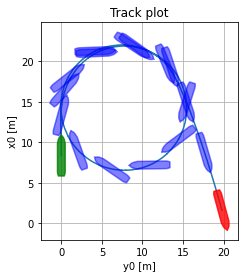

In [27]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [28]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2
#I_z_ = 900


ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

In [29]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

# Brix parameters

In [30]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)


mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)

df_parameters['brix_prime'].fillna(0, inplace=True)
#df_parameters['brix_SI'].fillna(0, inplace=True)



In [31]:
df_parameters.head()

,symbol,dof,coord,state,denominator,brix,brix_lambda,brix_prime
Xudot,X_{\dot{u}},X,u,dot,0.5*L**3*rho,2.0*m/(L**3*rho*(pi*sqrt(L**3/volume) - 14)),<function _lambdifygenerated at 0x000001625587...,0.000179
Xvdot,X_{\dot{v}},X,v,dot,0.5*L**3*rho,NaN,NaN,0.000000
Xrdot,X_{\dot{r}},X,r,dot,0.5*L**4*rho,NaN,NaN,0.000000
Yudot,Y_{\dot{u}},Y,u,dot,0.5*L**3*rho,NaN,NaN,0.000000
Yvdot,Y_{\dot{v}},Y,v,dot,0.5*L**3*rho,-pi*T**2*(-5.1*B**2/L**2 + 0.16*B*CB/T + 1)/L**2,<function _lambdifygenerated at 0x000001625587...,-0.006109


In [32]:
df_parameters['prime'] = df_parameters['brix_prime']

def to_SI(row):
    
    prime = row['prime']
    denominator = row['denominator']
    lamda = lambdify(denominator)
    try:
        denominator_value = run(lamda, inputs=ship_parameters)
        SI = prime*denominator_value
    except:
        return None
    else:
        return SI
    
df_parameters['brix_SI'] = df_parameters.apply(to_SI, axis=1)
    

In [33]:
df['Y_qs'] = run(Y_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_SI'])
df['X_qs'] = run(X_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_SI'])
df['N_qs'] = run(N_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_SI'])

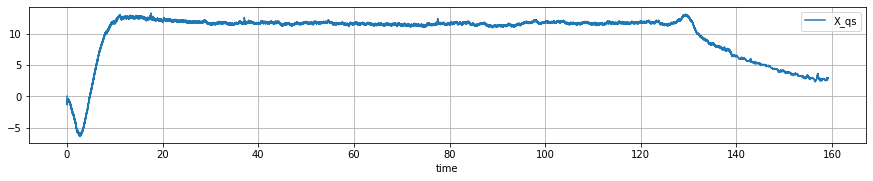

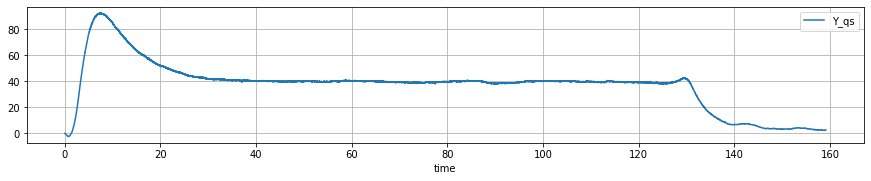

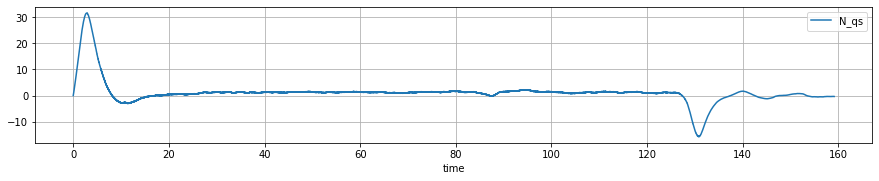

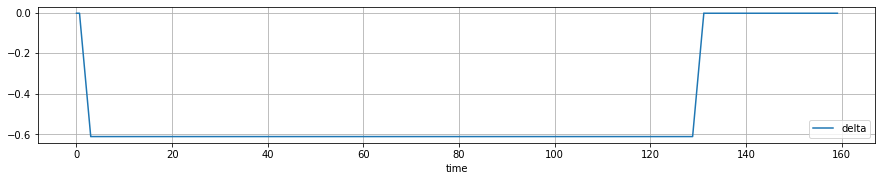

In [34]:
keys = ['X_qs','Y_qs','N_qs','delta']
for key in keys:
    fig,ax=plt.subplots()
    fig.set_size_inches(15,2.5)
    df.plot(y=key, ax=ax)
    ax.grid(True)

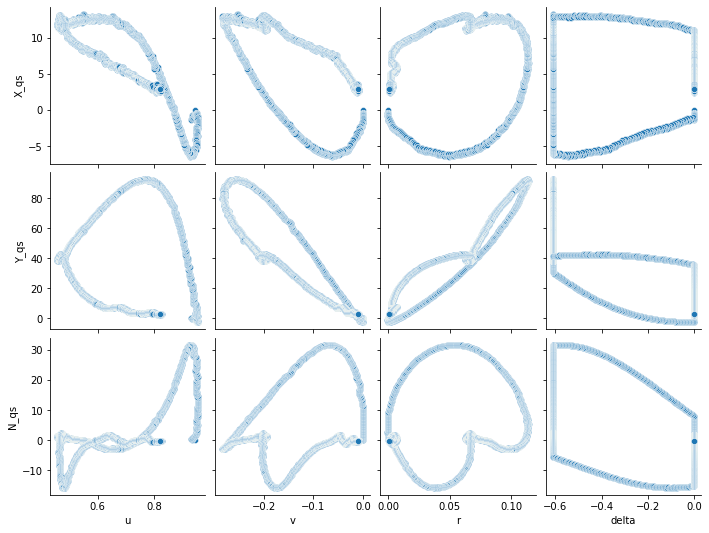

In [35]:
sns.pairplot(df, x_vars=['u','v','r','delta'], y_vars=['X_qs','Y_qs','N_qs'])

# Regression

## N

In [36]:
Math(vlatex(eq.N_qs_eq))

<IPython.core.display.Math object>

In [37]:
N_ = sp.symbols('N_')
diff_eq_N = regression.DiffEqToMatrix(ode=eq.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])

In [38]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{deltadeltadelta}],
[            N_{rrr}],
[             N_{uu}],
[    N_{rdeltadelta}],
[    N_{vdeltadelta}],
[        N_{rrdelta}],
[            N_{vrr}],
[        N_{uudelta}],
[            N_{uur}],
[            N_{uuv}],
[        N_{vvdelta}],
[            N_{vvr}],
[         N_{udelta}],
[             N_{ur}],
[             N_{uv}],
[        N_{vrdelta}],
[          N_{delta}],
[              N_{r}],
[              N_{v}]]))

In [39]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [40]:
diff_eq_N.eq_y

Eq(y, N_)

In [41]:
diff_eq_N.y_lambda

<function _lambdifygenerated(N_)>

In [42]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   N_qs   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          5.138e+04
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:32:53   Log-Likelihood:                         -14704.
No. Observations:               15915   AIC:                                  2.945e+04
Df Residuals:                   15896   BIC:                                  2.959e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Ndeltadeltadelta  -436.7933     20.495    -21.312      0.000    -476.966    -396.621
Nrrr             -3.245e+05   1.18e+04    -27.604      0.000   -3.48e+05   -3.01e+05
Nuu                  4.3658      0.069     63.386      0.000       4.231       4.501
Nrdeltadelta     -1.226e+04    465.824    -26.323      0.000   -1.32e+04   -1.13e+04
Nvdeltadelta     -1587.7146     33.764    -47.024      0.000   -1653.896   -1521.534
Nrrdelta         -1.191e+05   4080.073    -29.195      0.000   -1.27e+05   -1.11e+05
Nvrr             -1.429e+05   4056.583    -35.215      0.000   -1.51e+05   -1.35e+05
Nuudelta          -769.6445     17.499    -43.983      0.000    -803.944    -735.345
Nuur              5912.2708    255.001     23.185      0.000    5412.440    6412.102
Nuuv              4936.3826     64.995     75.950      0.000    4808.985    5063.780
Nvvdelta         -3582.2707    108.043    -33.156      0.000   -3794.046   -3370.495
Nvvr               -2.8e+04    696.959    -40.172      0.000   -2.94e+04   -2.66e+04
Nudelta            803.0349     24.772     32.417      0.000     754.479     851.591
Nur              -9089.1643    334.806    -27.148      0.000   -9745.422   -8432.907
Nuv              -6114.7899     77.868    -78.528      0.000   -6267.420   -5962.160
Nvrdelta         -3.151e+04    827.270    -38.084      0.000   -3.31e+04   -2.99e+04
Ndelta            -162.7047      8.808    -18.472      0.000    -179.970    -145.439
Nr                3407.2437    109.012     31.256      0.000    3193.568    3620.919
Nv                1910.2403     23.526     81.196      0.000    1864.126    1956.354
==============================================================================
Omnibus:                    11774.992   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           475342.941
Skew:                          -3.135   Prob(JB):                         0.00
Kurtosis:                      29.029   Cond. No.                     2.01e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

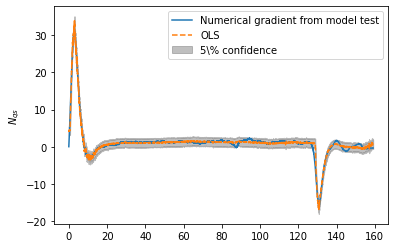

In [43]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['N_qs'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N_{qs}$')

## Y

In [44]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=eq.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Y_qs   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.947e+06
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:32:54   Log-Likelihood:                         -11472.
No. Observations:               15915   AIC:                                  2.298e+04
Df Residuals:                   15899   BIC:                                  2.310e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Yrrr         -1.597e+05   2590.120    -61.658      0.000   -1.65e+05   -1.55e+05
Yuu              0.6189      0.055     11.290      0.000       0.511       0.726
Yvvv         -9778.6794    152.907    -63.952      0.000   -1.01e+04   -9478.964
Yvdeltadelta    71.3613      9.293      7.679      0.000      53.145      89.577
Yvrr         -1.938e+05   2978.675    -65.070      0.000      -2e+05   -1.88e+05
Yuudelta       605.6698     11.396     53.146      0.000     583.332     628.008
Yuur          5618.7644    190.763     29.454      0.000    5244.848    5992.681
Yuuv           908.5922     57.093     15.914      0.000     796.683    1020.502
Yvvr         -7.161e+04   1082.477    -66.152      0.000   -7.37e+04   -6.95e+04
Yudelta       -745.8559     15.538    -48.004      0.000    -776.311    -715.401
Yur          -6543.9211    253.852    -25.778      0.000   -7041.500   -6046.342
Yuv          -1176.2667     72.383    -16.251      0.000   -1318.145   -1034.388
Yvrdelta     -1343.5025    146.559     -9.167      0.000   -1630.775   -1056.230
Ydelta         218.9715      4.971     44.049      0.000     209.228     228.715
Yr            2302.6585     81.793     28.152      0.000    2142.334    2462.983
Yv             284.5922     23.504     12.108      0.000     238.522     330.662
==============================================================================
Omnibus:                      145.982   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.842
Skew:                           0.046   Prob(JB):                     1.01e-51
Kurtosis:                       3.588   Cond. No.                     7.37e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

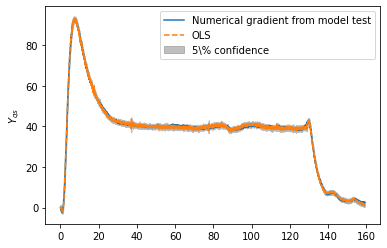

In [45]:
X = diff_eq_Y.calculate_features(data=df)
y = diff_eq_Y.calculate_label(y=df['Y_qs'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y_{qs}$')

## X

In [46]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=eq.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r,thrust])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   X_qs   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.216e+06
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                        0.00
Time:                        17:32:54   Log-Likelihood:                          4033.0
No. Observations:               15915   AIC:                                     -8034.
Df Residuals:                   15899   BIC:                                     -7911.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Xdeltadelta     56.5205      2.128     26.560      0.000      52.349      60.692
Xrr           1.379e+04    345.686     39.886      0.000    1.31e+04    1.45e+04
Xuu            -69.0057      1.303    -52.953      0.000     -71.560     -66.451
Xuuu            20.7077      0.750     27.629      0.000      19.239      22.177
Xvv            851.6345     18.359     46.389      0.000     815.650     887.619
Xudeltadelta  -131.8028      2.485    -53.035      0.000    -136.674    -126.932
Xurr          -2.03e+04    381.481    -53.220      0.000   -2.11e+04   -1.96e+04
Xuvv         -1376.1767     36.438    -37.768      0.000   -1447.599   -1304.755
Xrdelta       1196.5660     50.600     23.648      0.000    1097.385    1295.747
Xvdelta         74.4195      3.297     22.574      0.000      67.958      80.881
Xvr           5088.7214    102.119     49.831      0.000    4888.557    5288.886
Xurdelta     -2054.9686     53.201    -38.627      0.000   -2159.248   -1950.689
Xvrdelta      -364.9266     19.283    -18.924      0.000    -402.724    -327.129
Xuvr         -7818.0554    168.436    -46.415      0.000   -8148.210   -7487.901
Xthrust          0.0445      0.006      7.431      0.000       0.033       0.056
Xu              45.0433      0.622     72.463      0.000      43.825      46.262
==============================================================================
Omnibus:                     2900.017   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10561.449
Skew:                           0.890   Prob(JB):                         0.00
Kurtosis:                       6.571   Cond. No.                     4.76e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

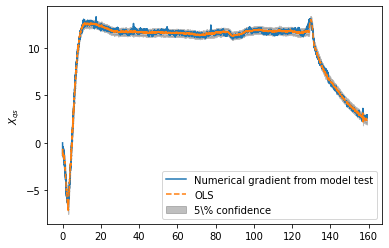

In [47]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['X_qs'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X_{qs}$')

In [48]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [49]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['SI'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_SI'])  # prefer regressed
df_parameters_all['SI'].fillna(0,inplace=True)

In [50]:
df_parameters_all.head()

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_SI,brix_prime,regressed,coord,denominator,dof,prime,state,symbol,SI
Ndelta,2.147982e-75,-145.439318,-179.970113,NaN,NaN,0.000000,-162.704715,delta,0.5*L**3*U**2*rho,N,0.000000,,N_{delta},-162.704715
Ndeltadelta,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,deltadelta,0.5*L**3*U**2*rho,N,0.000000,,N_{deltadelta},0.000000
Ndeltadeltadelta,2.146424e-99,-396.620669,-476.966016,NaN,NaN,0.000000,-436.793343,deltadeltadelta,0.5*L**3*U**2*rho,N,0.000000,,N_{deltadeltadelta},-436.793343
Nr,3.524522e-208,3620.919185,3193.568258,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,NaN,-0.001719,3407.243722,r,0.5*L**4*U*rho,N,-0.001719,,N_{r},3407.243722
Nrdelta,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,rdelta,0.5*L**4*U*rho,N,0.000000,,N_{rdelta},0.000000


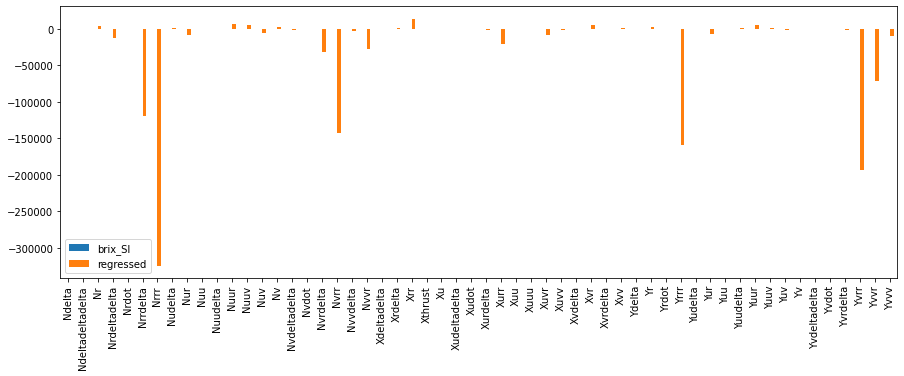

In [51]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
mask = ((df_parameters_all['brix_prime'] != 0) |
        (df_parameters_all['regressed']).notnull())
        
df_parameters_plot = df_parameters_all.loc[mask]
df_parameters_plot.plot.bar(y=['brix_SI','regressed'], ax=ax);

# Simulate captive

In [52]:
subs = {value:key for key,value in eq.p.items()}
X_qs_lambda = lambdify(eq.X_qs_eq.rhs.subs(subs))
Y_qs_lambda = lambdify(eq.Y_qs_eq.rhs.subs(subs))
N_qs_lambda = lambdify(eq.N_qs_eq.rhs.subs(subs))

In [53]:
df['X_qs_pred'] = run(function=X_qs_lambda, inputs=df, **df_parameters_all['SI'])
df['Y_qs_pred'] = run(function=Y_qs_lambda, inputs=df, **df_parameters_all['SI'])
df['N_qs_pred'] = run(function=N_qs_lambda, inputs=df, **df_parameters_all['SI'])


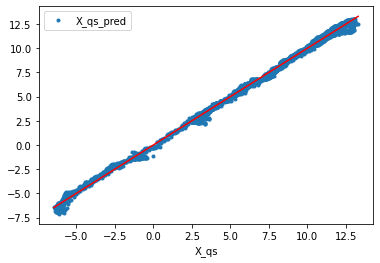

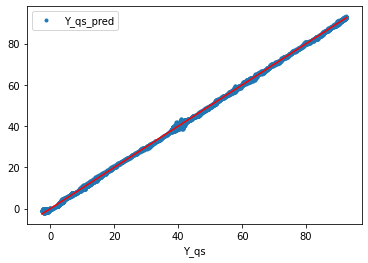

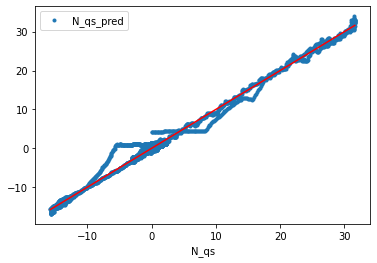

In [54]:
for key in ['X_qs','Y_qs','N_qs']:
    fig,ax=plt.subplots()
    df.plot(x=key, y=f'{key}_pred',style='.', ax=ax)
    ax.plot([df[key].min(), df[key].max()], [df[key].min(), df[key].max()], 'r-')

# Simulation

In [55]:
#X_eq = eq.X_eq.copy()
#Y_eq = eq.Y_eq.copy()
#N_eq = eq.N_eq.copy()
#
#eqs = [X_eq, Y_eq, N_eq]
#solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)
#
### Decouple the equations:
#u1d_eq = sp.Eq(u.diff(), solution[0][u.diff()]) 
#v1d_eq = sp.Eq(v.diff(), solution[0][v.diff()]) 
#r1d_eq = sp.Eq(r.diff(), solution[0][r.diff()])
#
#
### Lambdify:
#subs = {value:key for key,value in eq.p.items()}
#u1d_lambda = lambdify(u1d_eq.subs(subs).rhs)
#v1d_lambda = lambdify(v1d_eq.subs(subs).rhs)
#r1d_lambda = lambdify(r1d_eq.subs(subs).rhs)


u1d,v1d,r1d = sp.symbols('u1d, v1d, r1d')
subs = [
    (u.diff(),u1d),
    (v.diff(),v1d),
    (r.diff(),r1d),

]
eq_X_ = X_eq.subs(subs)
eq_Y_ = Y_eq.subs(subs)
eq_N_ = N_eq.subs(subs)


A,b = sp.linear_eq_to_matrix([eq_X_,eq_Y_,eq_N_],[u1d,v1d,r1d])

acceleartion_eq = A.inv()*b
## Lambdify:
subs = {value:key for key,value in eq.p.items()}
subs[X_qs] = sp.symbols('X_qs')
subs[Y_qs] = sp.symbols('Y_qs')
subs[N_qs] = sp.symbols('N_qs')

acceleartion_lambda = lambdify(acceleartion_eq.subs(subs))

In [56]:
A

Matrix([
[-X_{\dot{u}} + m,                       -X_{\dot{v}},         -X_{\dot{r}}],
[    -Y_{\dot{u}},                   -Y_{\dot{v}} + m, -Y_{\dot{r}} + m*x_G],
[               0, -N_{\dot{u}} - N_{\dot{v}} + m*x_G,    I_z - N_{\dot{r}}]])

In [57]:
b

Matrix([
[-m*(-x_G*r(t)**2 - r(t)*v(t)) + X_qs(u(t), v(t), r(t), delta(t))],
[                 -m*r(t)*u(t) + Y_qs(u(t), v(t), r(t), delta(t))],
[             -m*x_G*r(t)*u(t) + N_qs(u(t), v(t), r(t), delta(t))]])

In [58]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, ship_parameters, control):

    u,v,r,x0,y0,psi = states
    
    #if u < 0:
    #    dstates = [
    #    0,
    #    0,
    #    0,
    #    0,
    #    0,
    #    0,
    #    ]    
    #    return dstates
    
    states_dict = {
        'u':u,
        'v':v,
        'r':r,
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
    
    inputs = dict(parameters)
    inputs.update(ship_parameters)
    inputs.update(states_dict)
    
    if isinstance(control, pd.DataFrame):
        index = np.argmin(np.array(np.abs(control.index - t)))
        control_ = dict(control.iloc[index])
    else:
        control_ = control
    inputs.update(control_)
    
    #inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    
    inputs['X_qs'] = run(function=X_qs_lambda, inputs=inputs)
    inputs['Y_qs'] = run(function=Y_qs_lambda, inputs=inputs)
    inputs['N_qs'] = run(function=N_qs_lambda, inputs=inputs)
    
    u1d,v1d,r1d = run(function=acceleartion_lambda, inputs=inputs)
    
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    
    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    return dstates

In [59]:
def simulate(df_, parameters, ship_parameters):
    
    t = df_.index
    t_span = [t.min(),t.max()]
    t_eval = np.linspace(t.min(),t.max(),len(t))
    
    control = df_[['delta','thrust']]
    #control = {
    #    'delta': float(df_['delta'].mean()),
    #    'thrust': float(df_['thrust'].mean()),
    #    
    #}
    
    df_0 = df_.iloc[0:100].median(axis=0)
    y0 = {
        'u' : df_0['u'], 
        'v' : df_0['v'],
        'r' : df_0['r'],
        'x0' : df_0['x0'],
        'y0' : df_0['y0'],
        'psi' : df_0['psi']
        }
    
    solution = solve_ivp(fun=step, t_span=t_span, y0=list(y0.values()), t_eval=t_eval, 
                args=(parameters, ship_parameters, control))
    
    columns = list(y0.keys())
    df_result = pd.DataFrame(data=solution.y.T, columns=columns)
    df_result.index=t[0:len(df_result)]
    
    df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])
    
    return solution, df_result

In [60]:
df_cut = df.iloc[2000:].copy()
#df_cut = df.copy()
df_cut.index-=df_cut.index[0]
solution, df_result = simulate(df_cut, parameters = df_parameters_all['SI'], 
                               ship_parameters=ship_parameters)

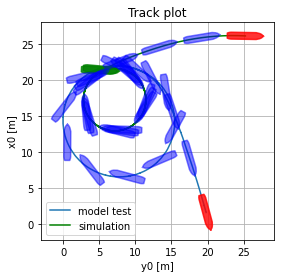

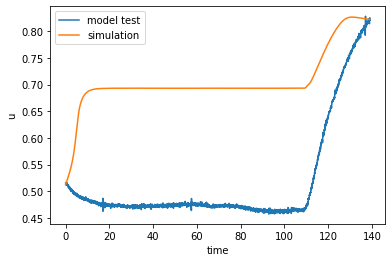

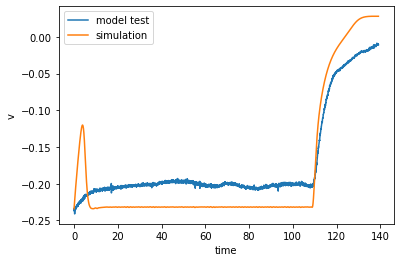

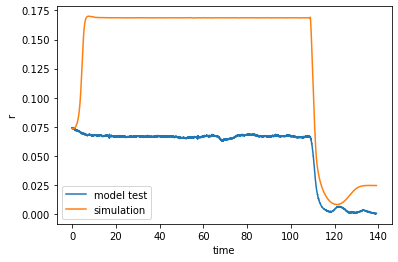

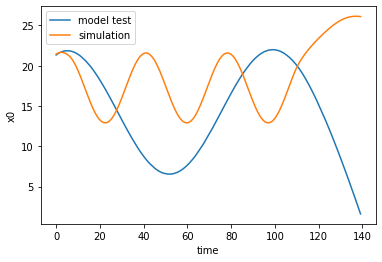

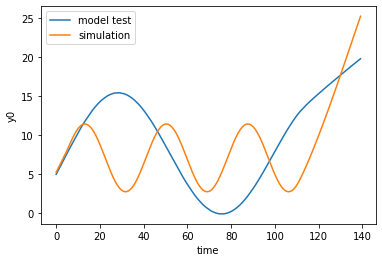

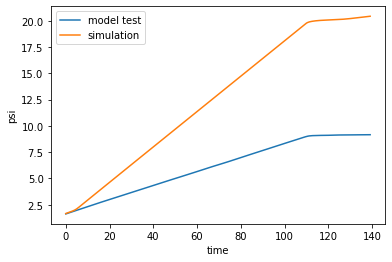

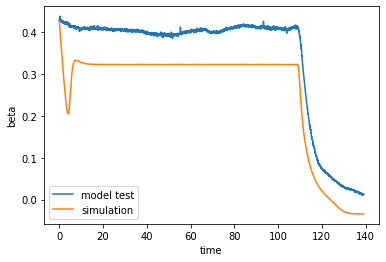

In [61]:
fig,ax=plt.subplots()
track_plot(df=df_cut, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df_cut.plot(y=key, label='model test', ax=ax)
    df_result.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)